In [1]:
%pip install numpy pandas matplotlib seaborn tensorflow keras opencv-python tqdm scikit-learn

## Import Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tqdm import tqdm
import random

## Load and Parse Annotations

In [3]:
# Define dataset path
DATA_DIR = "data/vehicle_number_plate_detection"
IMAGE_DIR = os.path.join(DATA_DIR, "images")
LABEL_DIR = os.path.join(DATA_DIR, "labels")
IMAGE_EXT = ".jpg"

# Function to parse YOLO annotation files
def parse_yolo_annotation(txt_file):
    with open(txt_file, "r") as file:
        annotations = []
        for line in file:
            parts = line.strip().split()
            label = int(parts[0])  # class label
            
            # Normalized center coordinates and dimensions
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Get the image filename (assuming image and annotation share the same basename)
            filename = txt_file.replace(".txt", IMAGE_EXT)

            # Store the normalized values
            annotations.append((filename, x_center, y_center, width, height, label))

    return annotations

# Load all annotations
annotation_files = glob.glob(os.path.join(LABEL_DIR, "*.txt"))
data = []

for txt_file in tqdm(annotation_files, desc="Parsing Annotations"):
    data.extend(parse_yolo_annotation(txt_file))

# Convert to DataFrame
columns = ["filename", "center_x", "center_y", "width", "height", "label"]
df = pd.DataFrame(data, columns=columns)
df.head()

Parsing Annotations: 100%|██████████| 8078/8078 [01:33<00:00, 85.97it/s] 


,filename,center_x,center_y,width,height,label
0,data/vehicle_number_plate_detection\labels\202...,0.508677,0.415776,0.271814,0.069569,0
1,data/vehicle_number_plate_detection\labels\202...,0.818775,0.671229,0.187053,0.111533,0
2,data/vehicle_number_plate_detection\labels\202...,0.940699,0.428320,0.060487,0.071811,0
3,data/vehicle_number_plate_detection\labels\202...,0.878327,0.564796,0.207424,0.127523,0
4,data/vehicle_number_plate_detection\labels\202...,0.854865,0.488487,0.236695,0.151168,0


## Visualize Sample Bounding Boxes

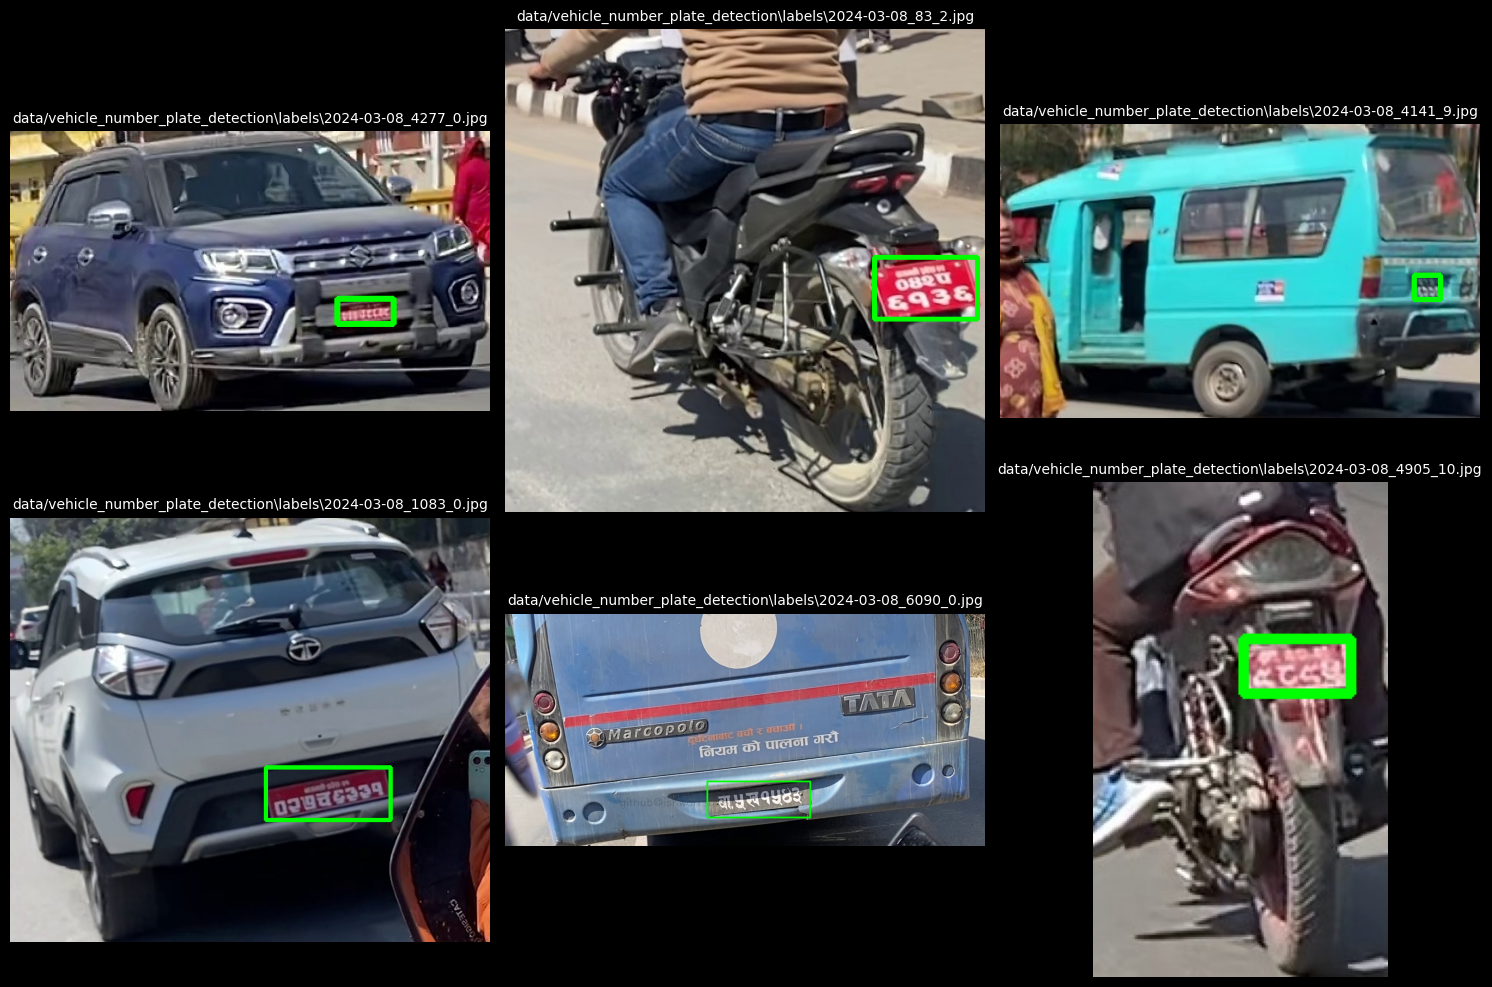

In [4]:

plt.style.use("dark_background")  # Enable dark mode

def show_sample_images(df, num_samples=6):
    sample_files = df["filename"].unique()
    num_samples = min(num_samples, len(sample_files))  # Adjust if fewer images exist
    selected_files = random.sample(list(sample_files), num_samples)  # Random selection
    
    num_rows, num_cols = 2, 3  # 2 rows, 3 columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten for easy iteration

    for i, file in enumerate(selected_files):
        img_path = file.replace("labels", "images")  # Update path if necessary
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        sample_data = df[df["filename"] == file]
        for _, row in sample_data.iterrows():
            # Convert from YOLO format to (xmin, ymin, xmax, ymax)
            x_center, y_center, width, height = row["center_x"], row["center_y"], row["width"], row["height"]
            xmin = int((x_center - width / 2) * img.shape[1])
            ymin = int((y_center - height / 2) * img.shape[0])
            xmax = int((x_center + width / 2) * img.shape[1])
            ymax = int((y_center + height / 2) * img.shape[0])

            # Draw bounding box
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(file, fontsize=10, color="white")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig("sample_images.png", dpi=300, bbox_inches="tight")
    plt.show()

# Call the function
show_sample_images(df)

## Preprocess Data

### Data Augmentation

In [5]:
# Define image size
IMG_SIZE = (128, 128)

# Data Augmentation and Preprocessing (Combined)
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    rotation_range=15,    # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    zoom_range=0.2,      # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    shear_range=0.2,     # Random shear (shearing transformation)
    fill_mode="nearest",  # Filling mode for empty pixels after transformations
)

### Data Generator function

In [6]:
# Custom generator for images and bounding boxes
def data_generator(df, batch_size=32):
    while True:
        batch_indices = np.random.choice(df.index, batch_size)
        batch_data = df.loc[batch_indices]

        images = []
        bboxes = []

        for _, row in batch_data.iterrows():
            img_path = row["filename"].replace("labels", "images")
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMG_SIZE)
            
            images.append(img)
            bboxes.append([row["center_x"], row["center_y"], row["width"], row["height"]])

        images = np.array(images, dtype="float32") / 255.0  # Normalize inside generator
        bboxes = np.array(bboxes, dtype="float32")

        yield images, bboxes


In [7]:
# Define training and validation generators
batch_size = 32
train_generator = data_generator(df.sample(frac=0.8, random_state=42), batch_size=batch_size)
val_generator = data_generator(df.drop(df.sample(frac=0.8, random_state=42).index), batch_size=batch_size)

## Building the CNN Model

### Define the IoU Loss

In [8]:
def iou_loss(y_true, y_pred):
    # Cast y_true to float32 to match the type of y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Extract ground truth and predicted coordinates in x_center, y_center, width, height form
    center_x_true, center_y_true, width_true, height_true = tf.split(y_true, 4, axis=-1)
    center_x_pred, center_y_pred, width_pred, height_pred = tf.split(y_pred, 4, axis=-1)
    
    # Convert x_center, y_center, width, height to xmin, ymin, xmax, ymax
    xmin_true = center_x_true - width_true / 2
    ymin_true = center_y_true - height_true / 2
    xmax_true = center_x_true + width_true / 2
    ymax_true = center_y_true + height_true / 2

    xmin_pred = center_x_pred - width_pred / 2
    ymin_pred = center_y_pred - height_pred / 2
    xmax_pred = center_x_pred + width_pred / 2
    ymax_pred = center_y_pred + height_pred / 2
    
    # Calculate intersection area
    inter_x1 = tf.maximum(xmin_true, xmin_pred)
    inter_y1 = tf.maximum(ymin_true, ymin_pred)
    inter_x2 = tf.minimum(xmax_true, xmax_pred)
    inter_y2 = tf.minimum(ymax_true, ymax_pred)
    
    inter_area = tf.maximum(inter_x2 - inter_x1, 0) * tf.maximum(inter_y2 - inter_y1, 0)
    
    # Calculate union area
    true_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    
    union_area = true_area + pred_area - inter_area
    
    # IoU is the intersection area divided by union area
    iou = inter_area / (union_area + tf.keras.backend.epsilon())
    
    # Return 1 - IoU as loss (lower IoU means higher loss)
    return 1 - iou


### Compile the Convolutional Neural Network

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(4, activation="sigmoid")  # Bounding box output (center_x, center_y, width, height)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae", iou_loss])
model.summary()

c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\projects\ebook_object_detection\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,060 (24.86 MB)

 Trainable params: 6,517,060 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [10]:
EPOCHS = 100
BATCH_SIZE = 32

# Train the model using the custom data generator
history = model.fit(
    train_generator,  # Use the custom generator for training data
    steps_per_epoch=len(df.sample(frac=0.8, random_state=42)) // BATCH_SIZE,  # Number of batches per epoch
    validation_data=val_generator,  # Validation data generator
    validation_steps=len(df.drop(df.sample(frac=0.8, random_state=42).index)) // BATCH_SIZE,  # Number of validation batches
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 87s 389ms/step - iou_loss: 0.9154 - loss: 0.0297 - mae: 0.1187 - val_iou_loss: 0.8121 - val_loss: 0.0150 - val_mae: 0.0771
Epoch 2/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 92s 424ms/step - iou_loss: 0.8069 - loss: 0.0108 - mae: 0.0662 - val_iou_loss: 0.8051 - val_loss: 0.0138 - val_mae: 0.0720
Epoch 3/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 103s 472ms/step - iou_loss: 0.7666 - loss: 0.0088 - mae: 0.0577 - val_iou_loss: 0.7611 - val_loss: 0.0113 - val_mae: 0.0610
Epoch 4/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 69s 316ms/step - iou_loss: 0.7205 - loss: 0.0069 - mae: 0.0497 - val_iou_loss: 0.7193 - val_loss: 0.0111 - val_mae: 0.0592
Epoch 5/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 67s 307ms/step - iou_loss: 0.6895 - loss: 0.0059 - mae: 0.0444 - val_iou_loss: 0.7374 - val_loss: 0.0117 - val_mae: 0.0594
Epoch 6/100
218/218 ━━━━━━━━━━━━━━━━━━━━ 70s 323ms/step - iou_loss: 0.6633 - loss: 0.0050 - mae: 0.0401 - val_iou_loss: 0.7210 - val_loss: 0.0116 - val_mae: 0.0602
Epoch 7/100
218

### Save the Model

In [11]:
model.save("plate_detection_model.h5")  # Saves in HDF5 format

## Evaluating the Model

### Evaluate the Model on the Validation Set

In [30]:
# Evaluate the model on the validation set
val_loss, val_mae, val_iou = model.evaluate(val_generator, verbose=1)

print(f"Validation Loss (MSE): {val_loss:.4f}")
print(f"Validation Mean Absolute Error (MAE): {val_mae:.4f}")
print(f"Validation Mean IoU: {1 - val_iou:.4f}")  # Since our IoU loss is 1 - IoU

  11838/Unknown 2065s 174ms/step - iou_loss: 0.6138 - loss: 0.0134 - mae: 0.0541

KeyboardInterrupt: 

### Plot Training and Validation Loss

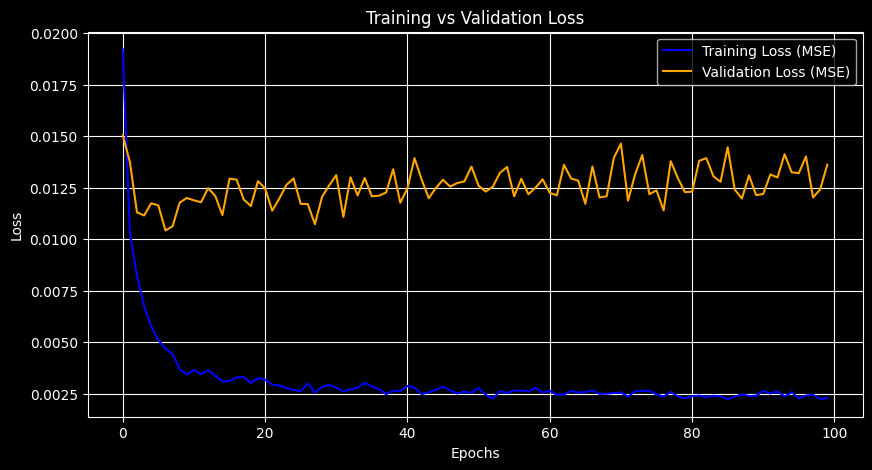

In [32]:
# Extract loss and validation loss from the history object
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss (MSE)", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss (MSE)", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.savefig("training_loss.png", dpi=300, bbox_inches="tight")
plt.show()

### Visualize Training and Validation MSE

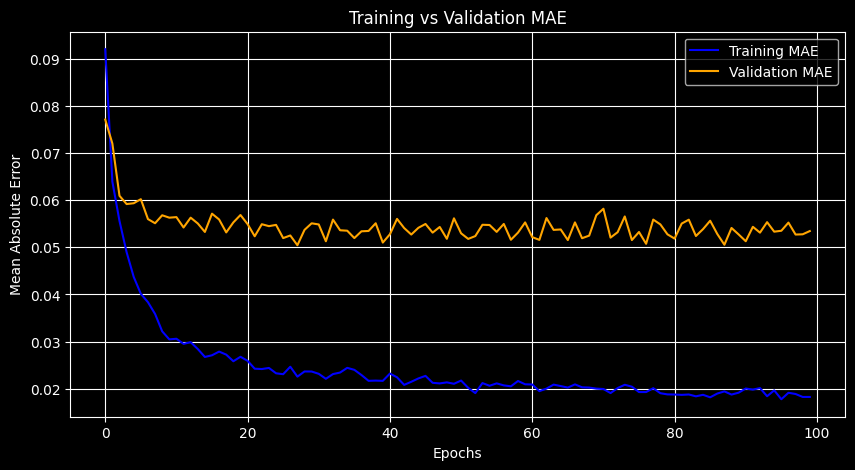

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["mae"], label="Training MAE", color="blue")
plt.plot(history.history["val_mae"], label="Validation MAE", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid()
plt.savefig("training_mae.png", dpi=300, bbox_inches="tight")
plt.show()

### Visualize Mean IoU During Training

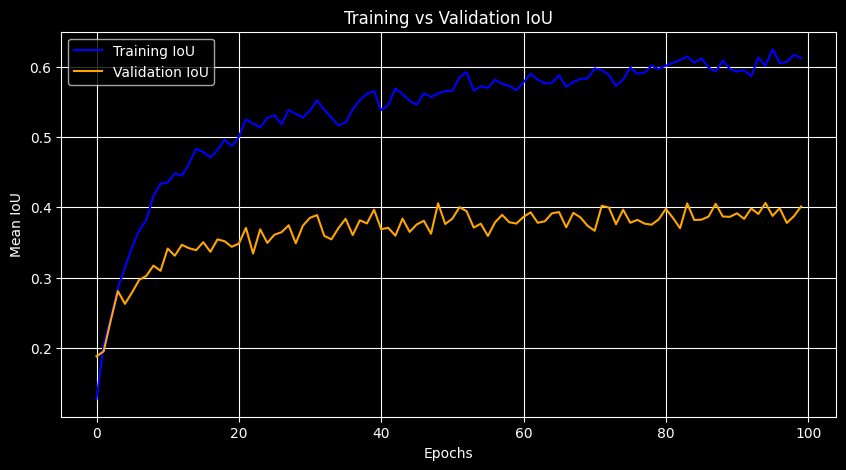

In [35]:
plt.figure(figsize=(10, 5))
plt.plot([1 - iou for iou in history.history["iou_loss"]], label="Training IoU", color="blue")
plt.plot([1 - iou for iou in history.history["val_iou_loss"]], label="Validation IoU", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Mean IoU")
plt.title("Training vs Validation IoU")
plt.legend()
plt.grid()
plt.savefig("training_iou.png", dpi=300, bbox_inches="tight")
plt.show()

## Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


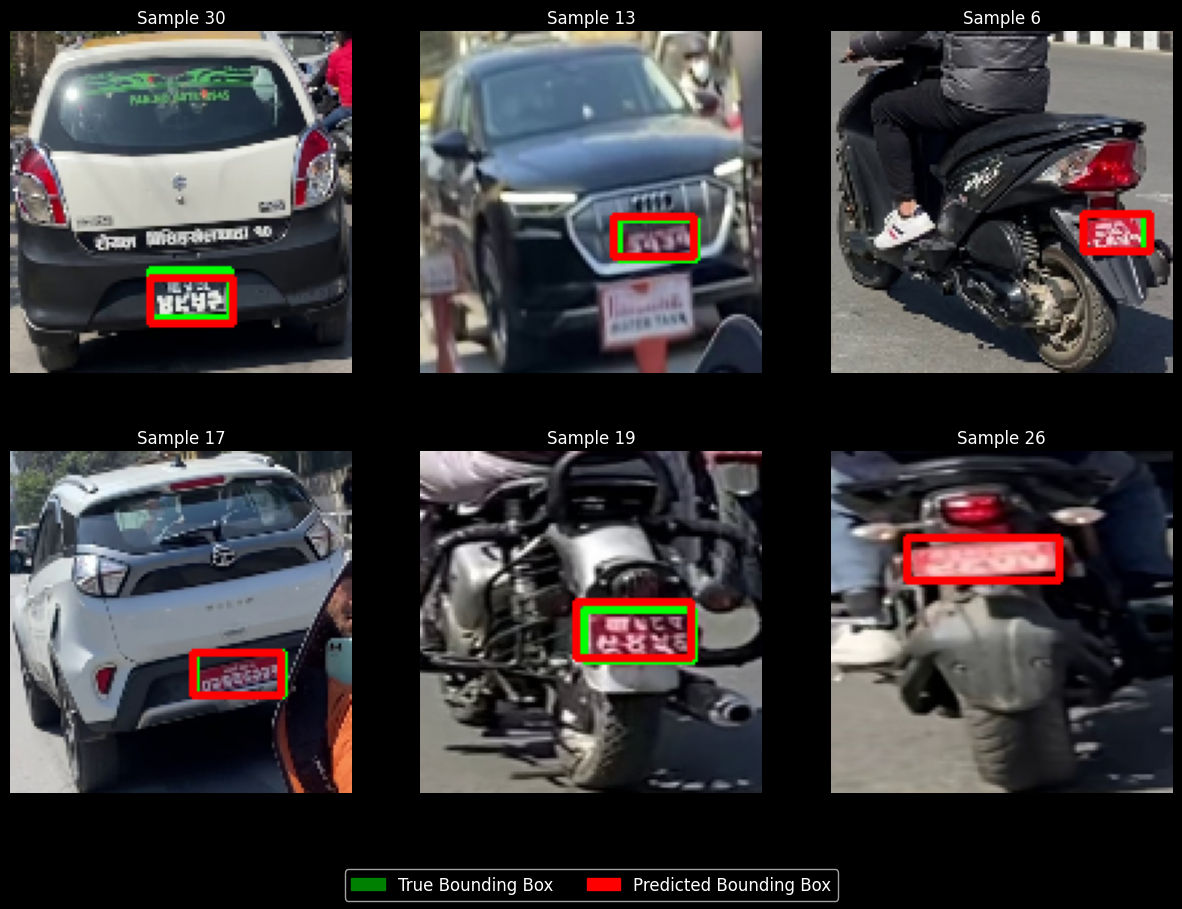

In [68]:
def visualize_predictions(model, data_generator, num_samples=6, save_path="predictions.png"):
    # Get a single batch from the generator
    X_batch, y_batch = next(data_generator)

    # Select random indices from the batch
    random_indices = random.sample(range(len(X_batch)), num_samples)

    # Predict bounding boxes for the selected samples
    preds = model.predict(X_batch[random_indices])

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2x3 grid

    for i, idx in enumerate(random_indices):
        img = (X_batch[idx] * 255).astype("uint8")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure RGB format

        # True bounding box (convert from center format to (xmin, ymin, xmax, ymax))
        true_x_center, true_y_center, true_width, true_height = y_batch[idx]
        true_xmin = int((true_x_center - true_width / 2) * IMG_SIZE[0])
        true_ymin = int((true_y_center - true_height / 2) * IMG_SIZE[1])
        true_xmax = int((true_x_center + true_width / 2) * IMG_SIZE[0])
        true_ymax = int((true_y_center + true_height / 2) * IMG_SIZE[1])

        # Predicted bounding box
        pred_x_center, pred_y_center, pred_width, pred_height = preds[i]
        pred_xmin = int((pred_x_center - pred_width / 2) * IMG_SIZE[0])
        pred_ymin = int((pred_y_center - pred_height / 2) * IMG_SIZE[1])
        pred_xmax = int((pred_x_center + pred_width / 2) * IMG_SIZE[0])
        pred_ymax = int((pred_y_center + pred_height / 2) * IMG_SIZE[1])

        # Draw bounding boxes (green for true, red for predicted)
        cv2.rectangle(img, (true_xmin, true_ymin), (true_xmax, true_ymax), (0, 255, 0), 2)  # True bbox in green
        cv2.rectangle(img, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (255, 0, 0), 2)  # Pred bbox in red

        # Place image in correct subplot
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Sample {idx+1}")

    # Add legend
    green_patch = mpatches.Patch(color='green', label='True Bounding Box')
    red_patch = mpatches.Patch(color='red', label='Predicted Bounding Box')
    fig.legend(handles=[green_patch, red_patch], loc="lower center", fontsize=12, ncol=2)

    # Save the figure
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    
    # Show the figure
    plt.show()

# Call the function to visualize predictions and save the image
visualize_predictions(model, train_generator, save_path="bbox_predictions.png")
